In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
import statsmodels.api as sm
import statslib as stb
import tensorflow as tf
import seaborn as sns

In [4]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset

In [5]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [6]:
from gmt.fom.gas.shared.models.stpb.data.mongo import MongoAdapter

In [7]:
figsize=(9*1.6, 9)

In [8]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [9]:
def get_fourier_series(timeIndex,K):
    m = 7
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.RangeIndex(1,len(timeIndex)+1))

    for i in range(1, K+1):
        fourier_series[f'S{i}-{m}'] = np.sin(2 * i * np.pi * d *fourier_series.index/ m)
        fourier_series[f'C{i}-{m}'] = np.cos(2 * i * np.pi * d *fourier_series.index/ m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = timeIndex
    return fourier_series

# CONSTANTS

In [10]:
YEARS = 3

In [11]:
FORECAST_HORIZON = 1; FORECAST_HORIZON

1

In [12]:
INPUT_WIDTH = 100; INPUT_WIDTH 

100

# DATA

In [13]:
myData = MongoAdapter()
data = myData.load_design_matrix()

2021-04-20 15:35:21,589: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.
2021-04-20 15:35:21,659: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 75: INFO: Retrieving....


In [14]:
#<------- TRAIN --------- VALIDATION -------- TEST -------->

In [15]:
train_up_to_idx = data.index.min() + DateOffset(years=YEARS)
train_idx = data.truncate(after=train_up_to_idx).index

In [16]:
pred_idx = data.loc[train_up_to_idx+ DateOffset(days=1):].iloc[:-FORECAST_HORIZON].index

In [17]:
out_t_idx = data[-FORECAST_HORIZON:].index

In [18]:
val_idx = sorted(set(data.index).difference(set(train_idx).union(pred_idx).union(out_t_idx)))

In [19]:
print(f'train_idx={len(train_idx)}\nval_idx={len(val_idx)}\npred_idx={len(pred_idx)}\nout_t_idx={len(out_t_idx)}')

train_idx=1097
val_idx=0
pred_idx=772
out_t_idx=1


In [20]:
assert len(train_idx)+len(val_idx)+len(pred_idx)+len(out_t_idx)==data.shape[0]

In [21]:
#Enrich for Design Matrix

In [22]:
#fourier series
K = 3
data = data.join(get_fourier_series(data.index,K))

In [23]:
dependent_var = ['gas']; dependent_var
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind']
fourier_cols =  [k for k in data if k.startswith('S') or k.startswith('C')]

In [24]:
y = data[dependent_var]; f = stb.transforms.identical();
gs = dict()
g1 = stb.transforms.identical();
gs.update(dict(zip(covariates, [g1]*len(covariates))))
g2 = stb.transforms.identical()
gs.update(dict(zip(fourier_cols, [g2]*len(fourier_cols))))
X = data[covariates  + fourier_cols ]; 

In [25]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=False)

In [26]:
train_df = DM.dm.loc[train_idx].drop('y', axis=1).rename(columns=DM.names)
val_df = DM.dm.loc[val_idx].drop('y', axis=1).rename(columns=DM.names)
pred_df =DM.dm.loc[pred_idx].drop('y', axis=1).rename(columns=DM.names)
out_df =DM.dm.loc[out_t_idx].drop('y', axis=1).rename(columns=DM.names)

In [27]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
pred_df = (pred_df - train_mean) / train_std

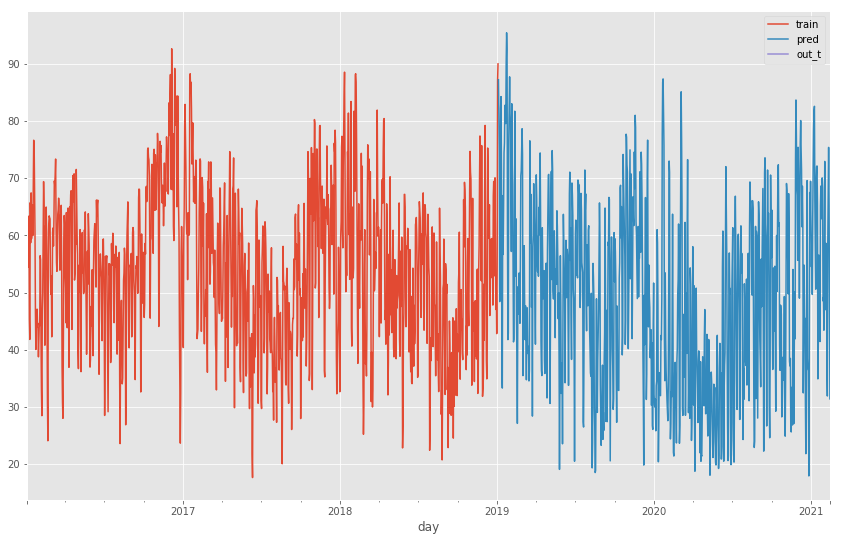

In [28]:
fig, ax = plt.subplots(figsize=figsize)
DM.y.loc[train_idx].plot(ax=ax)
# DM.y.loc[val_idx].plot(ax=ax)
DM.y.loc[pred_idx].plot(ax=ax)
DM.y.loc[out_t_idx].plot(ax=ax)
plt.legend(['train', 'pred', 'out_t'])
plt.show()

# STANDARDIZATION OF FEATURES

In [29]:
train_df.tail(1)

gas  clean_spreads  dark_spreads    precip  temperature  \
day                                                                        
2019-01-03  2.652855       0.968636      0.969957 -0.831042    -1.582688   

                wind      S1-7      C1-7      S2-7      C2-7      S3-7  \
day                                                                      
2019-01-03 -1.596153 -1.378647 -0.312568  0.612041 -1.272638  1.103797   

                C3-7  
day                   
2019-01-03  0.882126

In [30]:
pred_df.head(1)

gas  clean_spreads  dark_spreads    precip  temperature  \
day                                                                        
2019-01-04  2.447107       0.968636      0.969957 -0.831042    -1.423789   

                wind      S1-7      C1-7      S2-7      C2-7     S3-7  \
day                                                                     
2019-01-04 -0.873833 -1.105789  0.883753 -1.379323 -0.313561 -0.61343   

                C3-7  
day                   
2019-01-04 -1.274397

In [31]:
pred_df.tail(1)

gas  clean_spreads  dark_spreads    precip  temperature  \
day                                                                        
2021-02-13 -1.690671        1.26827      0.771833  0.469003    -1.965121   

                wind      S1-7      C1-7      S2-7      C2-7      S3-7  \
day                                                                      
2021-02-13  2.210898 -0.001007  1.416166 -0.001256  1.414635 -0.000559   

                C3-7  
day                   
2021-02-13  1.414744

In [32]:
out_df

gas  clean_spreads  dark_spreads    precip  temperature  \
day                                                                         
2021-02-14  28.729955      -3.671167    -20.950105  6.682667     3.331818   

             wind      S1-7     C1-7      S2-7      C2-7      S3-7      C3-7  
day                                                                           
2021-02-14  6.125  0.781831  0.62349  0.974928 -0.222521  0.433884 -0.900969

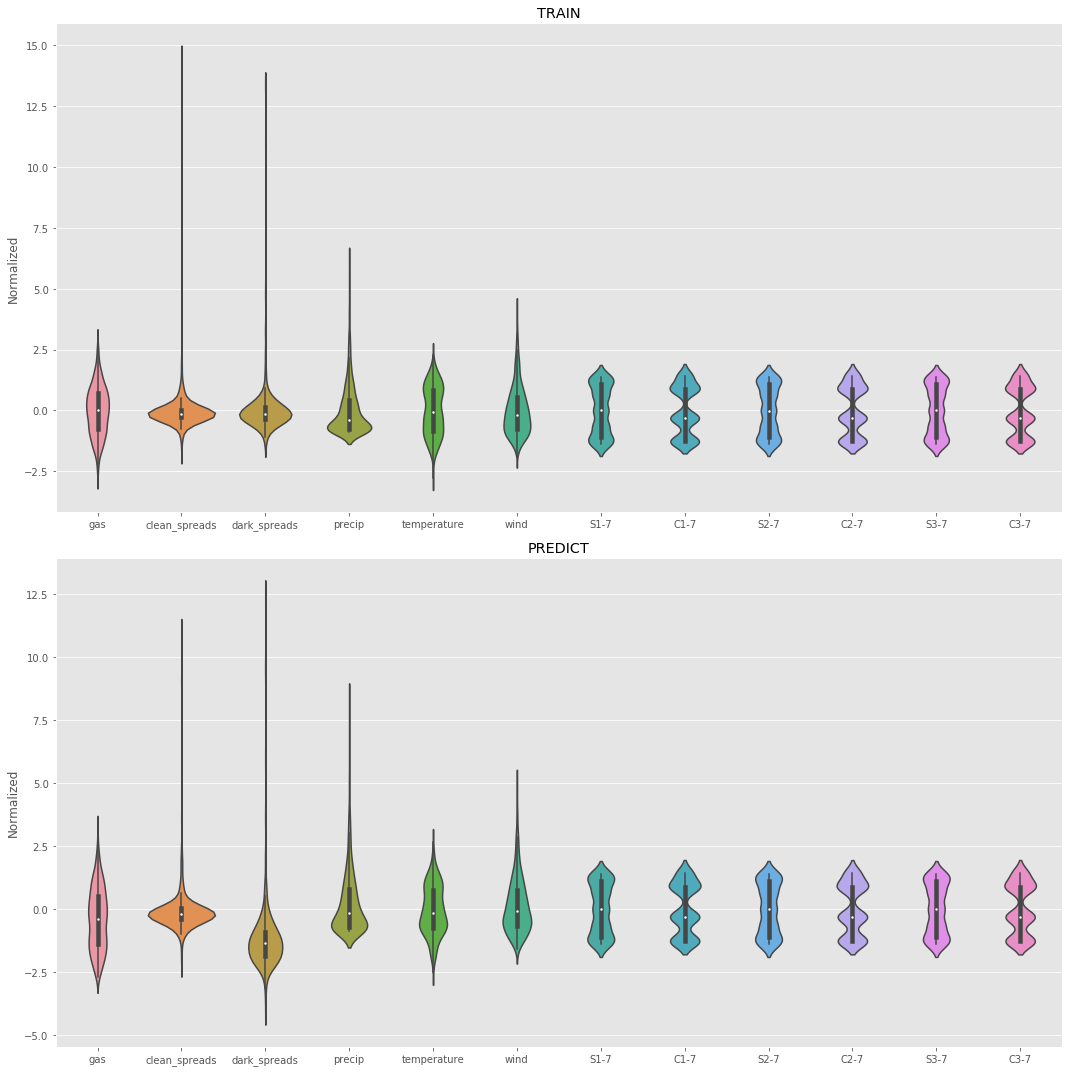

In [33]:
fig, (ax1,ax3) = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
_ = train_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax1)
# _ = val_df.melt(var_name='Column', value_name='Normalized')
# sns.violinplot(x="Column", y="Normalized", data=_, ax=ax2)
_ = pred_df.melt(var_name='Column', value_name='Normalized')
sns.violinplot(x="Column", y="Normalized", data=_, ax=ax3)
ax1.set_title('TRAIN')
# ax2.set_title('VALIDATE')
ax3.set_title('PREDICT')
ax1.set_xlabel('')
# ax2.set_xlabel('')
ax3.set_xlabel('')
plt.tight_layout()
plt.show()

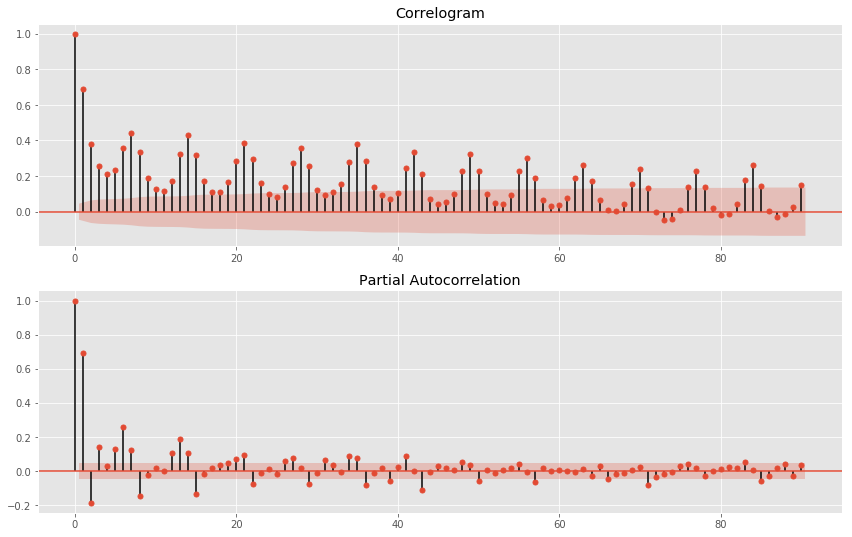

In [34]:
stb.stat_plots.plot_acf_pcf(y, kwargs_acf=dict(lags=90), kwargs_pacf=dict(lags=90))

# WINDOWS GENERATOR

In [35]:
INP_W = 7*2
OUT_W = 7*2
BATC_S = 1
SHUFFLE = False

print(f'INP_W={INP_W} OUT_W={OUT_W} BATC_S={BATC_S} SHUFFLE={SHUFFLE}')

INP_W=14 OUT_W=14 BATC_S=1 SHUFFLE=False


In [36]:
window = stb.WindowGenerator(
                         input_width=INP_W,
                         label_width=OUT_W,
                         shift=OUT_W,
                         train_df=train_df,
                         val_df=None,
                         test_df=pred_df,
                         label_columns=['gas'])

In [37]:
window

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): ['gas']

In [38]:
window.config(shuffle=SHUFFLE, batch_size=BATC_S)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 1}


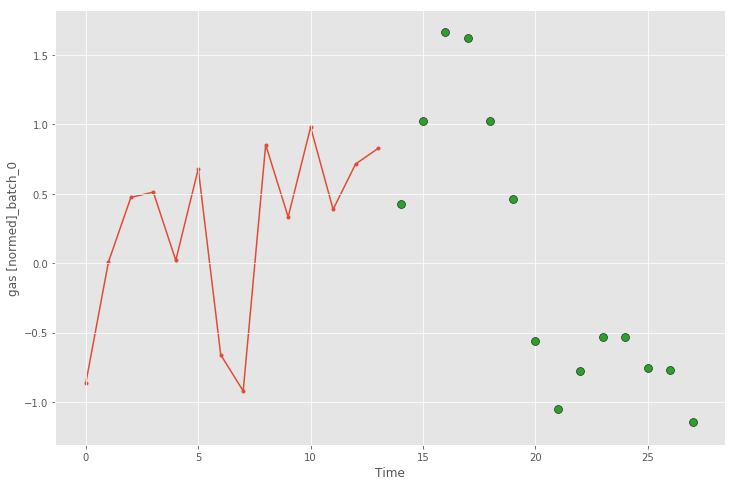

In [39]:
window.plot('gas')

# Long Short Term Memory RNN

In [40]:
lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(units=128, activation='relu',return_sequences=True),
    tf.keras.layers.LSTM(units=64, activation='relu',return_sequences=False),
    tf.keras.layers.Dense(units=OUT_W)
])

In [41]:
print('Input shape (batch_size, input_days, num_features):', window.example[0].shape)
print('Output shape (batch_size, output_days):', lstm_model(window.example[0]).shape)

Input shape (batch_size, input_days, num_features): (1, 14, 12)
Output shape (batch_size, output_days): (1, 14)


In [42]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=4, learning_rate=5e-3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=learning_rate),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, 
                      epochs=MAX_EPOCHS,
                      callbacks=[early_stopping])
  return history

In [43]:
history = compile_and_fit(lstm_model,window)

Epoch 1/200
1070/1070 [==============================] - 19s 12ms/step - loss: 0.7515 - mean_squared_error: 0.7515
Epoch 2/200
1070/1070 [==============================] - 11s 10ms/step - loss: 0.7731 - mean_squared_error: 0.7731
Epoch 3/200
1070/1070 [==============================] - 12s 11ms/step - loss: 2.1506 - mean_squared_error: 2.1506
Epoch 4/200
1070/1070 [==============================] - 11s 10ms/step - loss: 0.7484 - mean_squared_error: 0.7484
Epoch 5/200
1070/1070 [==============================] - 11s 10ms/step - loss: 0.7361 - mean_squared_error: 0.7361
Epoch 6/200
1070/1070 [==============================] - 11s 10ms/step - loss: 0.7139 - mean_squared_error: 0.7139
Epoch 7/200
1070/1070 [==============================] - 10s 10ms/step - loss: 2.6528 - mean_squared_error: 2.6528
Epoch 8/200
1070/1070 [==============================] - 11s 10ms/step - loss: 2.3616 - mean_squared_error: 2.3616
Epoch 9/200
1070/1070 [==============================] - 11s 10ms/step - loss: 3

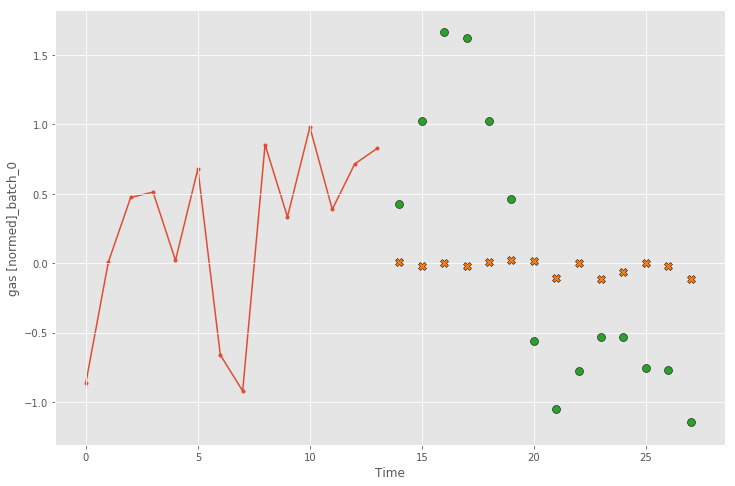

In [44]:
res = window.plot('gas', model=lstm_model)

In [45]:
w_pred = stb.WindowGenerator(
            input_width=INP_W,
            label_width=0,
            shift=0,
            train_df=pred_df.head(INP_W),
            val_df=None,
            test_df=None,
            label_columns=['gas'])

w_pred.config(shuffle=False, batch_size=1)

{'targets': None, 'sequence_stride': 1, 'shuffle': False, 'batch_size': 1}


In [46]:
pred_df.head(INP_W+OUT_W).tail(OUT_W)

gas  clean_spreads  dark_spreads    precip  temperature  \
day                                                                        
2019-01-18  1.625809      -0.308341     -0.228350  0.223899    -1.761216   
2019-01-19  2.115342      -0.308341     -0.228350 -0.632139    -1.418181   
2019-01-20  2.082382      -0.391225     -0.289700 -0.732849    -1.500434   
2019-01-21  1.878261      -0.138296     -0.039034  1.125257    -1.577080   
2019-01-22  2.669684       0.120863      0.082524  0.178580    -1.666811   
2019-01-23  3.055438       0.613674      0.614842 -0.571713    -1.939744   
2019-01-24  2.841230       3.596249      3.674189 -0.571713    -1.657464   
2019-01-25  0.453142       3.596249      3.674189 -0.571713    -0.661072   
2019-01-26 -0.922777       3.596249      3.674189  1.815124    -0.612468   
2019-01-27 -0.837413      -0.953004     -1.128594 -0.405541    -1.156464   
2019-01-28  1.662372      -0.066200     -0.119604 -0.030394    -1.643444   
2019-01-29  2.055643       0.086056      0.012407 -0.030394    -1.778041   
2019-01-30  2.484459       0.763229      0.691329 -0.030394    -1.974328   
2019-01-31  2.005918       0.041216     -0.065353  0.344752    -2.373445   

                wind      S1-7      C1-7      S2-7      C2-7      S3-7  \
day                                                                      
2019-01-18 -0.117522 -1.105789  0.883753 -1.379323 -0.313561 -0.613430   
2019-01-19 -0.729369 -0.001007  1.416166 -0.001256  1.414635 -0.000559   
2019-01-20 -1.358213  1.103775  0.883753  1.376810 -0.313561  0.612313   
2019-01-21 -0.482931  1.376633 -0.312568 -0.614554 -1.272638 -1.104915   
2019-01-22 -0.389454  0.612101 -1.271943 -1.106380  0.882388  1.376551   
2019-01-23 -0.967310 -0.614115 -1.271943  1.103867  0.882388 -1.377668   
2019-01-24 -1.579157 -1.378647 -0.312568  0.612041 -1.272638  1.103797   
2019-01-25  0.698275 -1.105789  0.883753 -1.379323 -0.313561 -0.613430   
2019-01-26  1.191152 -0.001007  1.416166 -0.001256  1.414635 -0.000559   
2019-01-27  3.069184  1.103775  0.883753  1.376810 -0.313561  0.612313   
2019-01-28 -0.151513  1.376633 -0.312568 -0.614554 -1.272638 -1.104915   
2019-01-29 -0.338467  0.612101 -1.271943 -1.106380  0.882388  1.376551   
2019-01-30 -1.009799 -0.614115 -1.271943  1.103867  0.882388 -1.377668   
2019-01-31 -0.737867 -1.378647 -0.312568  0.612041 -1.272638  1.103797   

                C3-7  
day                   
2019-01-18 -1.274397  
2019-01-19  1.414744  
2019-01-20 -1.274397  
2019-01-21  0.882126  
2019-01-22 -0.314654  
2019-01-23 -0.314654  
2019-01-24  0.882126  
2019-01-25 -1.274397  
2019-01-26  1.414744  
2019-01-27 -1.274397  
2019-01-28  0.882126  
2019-01-29 -0.314654  
2019-01-30 -0.314654  
2019-01-31  0.882126

In [47]:
fl = stb.utils.common.flatten_lst

In [48]:
fl(lstm_model.predict(w_pred.train))

[0.0069232285,
 -0.018335104,
 0.0034929442,
 -0.020339314,
 0.010294896,
 0.023465449,
 0.01453434,
 -0.10414513,
 0.00034634786,
 -0.11403557,
 -0.062775746,
 0.0014045435,
 -0.01768242,
 -0.112225965]

In [49]:
fl = stb.utils.common.flatten_lst

In [50]:
idx = pred_df.shift(INP_W).dropna().head(OUT_W).index; idx

DatetimeIndex(['2019-01-18', '2019-01-19', '2019-01-20', '2019-01-21',
               '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25',
               '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', name='day', freq=None)

In [51]:
predicted = fl(lstm_model.predict(w_pred.train)); predicted

[0.0069232285,
 -0.018335104,
 0.0034929442,
 -0.020339314,
 0.010294896,
 0.023465449,
 0.01453434,
 -0.10414513,
 0.00034634786,
 -0.11403557,
 -0.062775746,
 0.0014045435,
 -0.01768242,
 -0.112225965]

In [52]:
v_hat = pd.Series(predicted, index=idx); v_hat

day
2019-01-18    0.006923
2019-01-19   -0.018335
2019-01-20    0.003493
2019-01-21   -0.020339
2019-01-22    0.010295
2019-01-23    0.023465
2019-01-24    0.014534
2019-01-25   -0.104145
2019-01-26    0.000346
2019-01-27   -0.114036
2019-01-28   -0.062776
2019-01-29    0.001405
2019-01-30   -0.017682
2019-01-31   -0.112226
dtype: float64

In [53]:
v = pred_df.loc[idx]['gas']; v

day
2019-01-18    1.625809
2019-01-19    2.115342
2019-01-20    2.082382
2019-01-21    1.878261
2019-01-22    2.669684
2019-01-23    3.055438
2019-01-24    2.841230
2019-01-25    0.453142
2019-01-26   -0.922777
2019-01-27   -0.837413
2019-01-28    1.662372
2019-01-29    2.055643
2019-01-30    2.484459
2019-01-31    2.005918
Name: gas, dtype: float64

In [54]:
y_hat = v_hat*train_std['gas']+train_mean['gas']; y_hat

day
2019-01-18    54.326794
2019-01-19    53.986064
2019-01-20    54.280520
2019-01-21    53.959028
2019-01-22    54.372277
2019-01-23    54.549945
2019-01-24    54.429467
2019-01-25    52.828503
2019-01-26    54.238073
2019-01-27    52.695083
2019-01-28    53.386568
2019-01-29    54.252348
2019-01-30    53.994869
2019-01-31    52.719495
dtype: float64

In [55]:
y = DM.dm.loc[y_hat.index]['y']; y

day
2019-01-18    76.165250
2019-01-19    82.768959
2019-01-20    82.324332
2019-01-21    79.570774
2019-01-22    90.246923
2019-01-23    95.450664
2019-01-24    92.561043
2019-01-25    60.346198
2019-01-26    41.785316
2019-01-27    42.936860
2019-01-28    76.658477
2019-01-29    81.963631
2019-01-30    87.748273
2019-01-31    81.292850
Name: y, dtype: float64

In [56]:
print(f'Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')

Error=27.6892


In [57]:
metric = stb.metrics.root_mean_squared_error

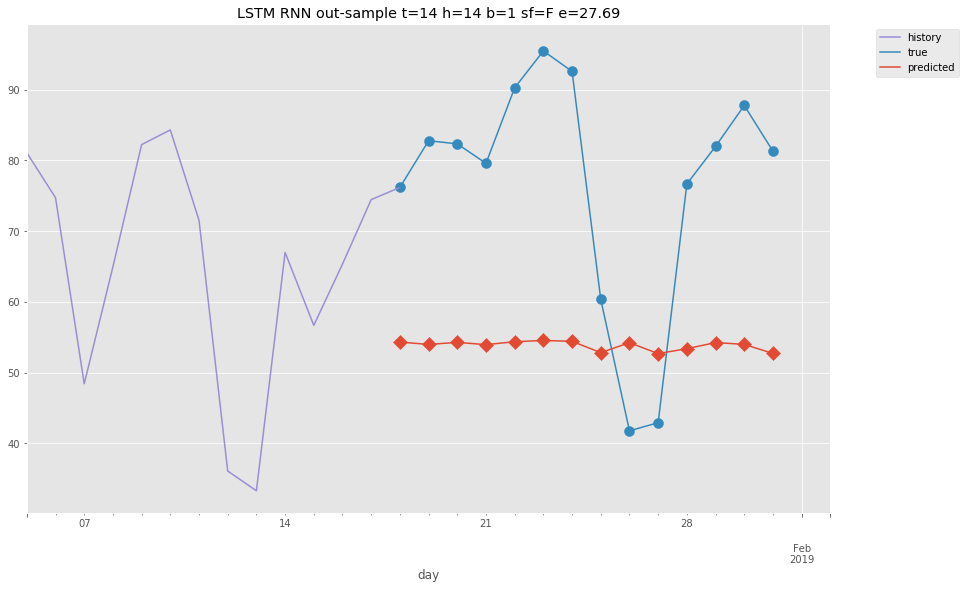

In [58]:
out_of_sample_error = metric(y, y_hat)

fig, ax =plt.subplots(figsize=figsize)
DM.dm.truncate(after=y_hat.index.min()).iloc[-int(INP_W):]['v'].plot(ax=ax, 
                                        color=stb.utils.plots.get_standard_colors()[2])
y.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[1])
y_hat.plot(ax=ax, color=stb.utils.plots.get_standard_colors()[0])

ax.scatter(y.index, y.values, 100, color=stb.utils.plots.get_standard_colors()[1])
ax.scatter(y_hat.index, y_hat.values, 100, marker='D', color=stb.utils.plots.get_standard_colors()[0])


ax.legend(['history', 'true', 'predicted'], bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(right=y.index.max() + DateOffset(days=2))

plt.title(f'ForecastHorizon={OUT_W}days | Error={stb.metrics.root_mean_squared_error(y, y_hat):.4f}')
title = f'LSTM RNN out-sample t={OUT_W} h={INP_W} b={BATC_S} sf={str(SHUFFLE)[0]} e={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()